NBA INJURY PREDICTOR

![](injury.jpeg)


Contents

1. [Introduction](#1-introduction)  
1.1 [Background](#11-background)  
1.2 [Objectives](#12-objectives)
2. [Data Preparation](#2-data-preparation)  
2.1 [Imports](#21-imports)  
2.2 [Google Cloud Storage](#22-GCS)  
2.3 [Dataframe Construction & Data Cleaning](#23-dfc&dc)  
2.4 [Feature Correlations](#24-ft_corr)
3. [Model Development](#3-MD).  
3.1[Training the Model](#31-TM)  
3.2[Plotting the Model](#32-PM)  
4. [Model Testing](#4-MT)  
4.1 [Plotting the Test Results](#4.1-PTR)  
5. [Conclusion](#5-Conc)

##  Introduction

### Background
<a id="11-background"><a>

The National Basketball Association (NBA) is one of the most popular and competitive professional sports leagues globally, captivating millions of fans with its fast-paced action and exceptional athleticism. However, along with the excitement and intensity of the game, player injuries have become a significant concern for teams, players, and fans alike.

Understanding and predicting the number of injuries that occur in the NBA year over year has become a crucial area of research and analysis. The impact of injuries goes beyond individual players, as it can significantly influence team performance, game strategies, and overall league dynamics. Building a predictive model for NBA injuries aims to gain valuable insights into injury patterns, risk factors, and the potential impact on team dynamics.

The importance of such a predictive model lies in its ability to assist various stakeholders in the NBA ecosystem. Team management can use the model to proactively manage player workload, optimize training and recovery protocols, and minimize injury risks. Coaches can adjust game strategies and rotations based on injury predictions, aiming to maximize player availability and team performance. Additionally, players themselves can benefit from injury forecasting by adopting personalized training programs and injury prevention measures.

Furthermore, the predictive model contributes to the broader field of sports science and sports medicine. By analyzing historical injury data and identifying factors that contribute to injuries, valuable insights can be gained into injury prevention, rehabilitation techniques, and overall player health and well-being.

By leveraging advanced data analysis and machine learning techniques, a robust predictive model for NBA injuries has been developed. This model considers various factors such as player workload, playing style, previous injury history, game schedule, and other relevant variables to forecast the likelihood of injuries occurring throughout the season. The model's predictions provide valuable information for teams, coaches, and players, enabling them to make data-driven decisions to enhance player safety, optimize performance, and ultimately elevate the overall quality of the NBA game.

Through this research, efforts have been made to contribute to the ongoing initiatives of the NBA and the sports community as a whole in promoting player health, reducing injury rates, and fostering a more sustainable and competitive environment.

### Objectives
<a id="12-objectives"></a>

The objectives of the NBA injury predictive model are twofold. Firstly, the model aims to accurately predict the total number of injuries that will occur in the NBA during a calendar season. By training the model on historical injury data and leveraging advanced machine learning techniques, it strives to provide reliable forecasts that can assist teams, coaches, and players in proactive injury management and planning.

Secondly, the model seeks to gain insights into the factors that have the greatest impact on the overall number of injuries in the NBA. These insights can contribute to a better understanding of injury risk factors and inform strategies for injury prevention and player safety.



## Data Preparation
<a id="2-data-preparation"></a>

### Imports
<a id="21-imports"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score 
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.ticker as ticker
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri


### Google Cloud Storage
<a id="22-GCS"><a>

In [2]:
from google.cloud import storage
import io
key_path = "/Users/antho/Documents/GCP/nba-injury-forecasting-59f4078886ad.json"
client = storage.Client.from_service_account_json(key_path)

In [3]:
bucket_name = 'nba-data-2023-v2'
bucket = client.get_bucket(bucket_name)

In [4]:
injData = 'Injuries.csv'
blob = bucket.blob(injData)
blob.download_to_filename(injData)
injuryData = pd.read_csv(injData)

In [5]:
# Download and store the data from AverageTravel.csv, AveragePlayerAge.csv, and NBASalaries.csv
blob_travel = bucket.blob('AverageTravel.csv')
content_travel = blob_travel.download_as_text()
annual_travel = pd.read_csv(io.StringIO(content_travel))

blob_age = bucket.blob('AveragePlayerAge.csv')
content_age = blob_age.download_as_text()
average_age = pd.read_csv(io.StringIO(content_age))

blob_salary = bucket.blob('NBASalaries.csv')
content_salary = blob_salary.download_as_text()
average_salary = pd.read_csv(io.StringIO(content_salary))

### Dataframe Construction & Data Cleaning
<a id="23-dfc&dc"></a>

In [6]:
injuryData.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
injuryData.rename(columns={'Notes': 'Injury Type'}, inplace=True)
injuryData.rename(columns={'Relinquished': 'Player'}, inplace=True)

In [7]:
# Setting the objects in the column to a pandas datetime object
injuryData['Date'] = pd.to_datetime(injuryData['Date'])

#Grouping rows by 'decade' column
injuryData['Year'] = (injuryData['Date'].dt.year)

>__Let's now remove all rows where the players have been acquired back from the IL__


In [8]:
# Removing the Acquired column removes all duplicates 
injuryData = injuryData[injuryData['Acquired'].isna()]
del injuryData['Acquired']

> __Now let's calculate the total sum of injuries for each Year__

 > ** *It is important to note that the NBA did not have and IR/IL until the 1989-1990 season. Prior to this injured players were still members of the active roster. For this reason, it's likely many injuries do not appear in the dataset.*

In [9]:
# We only want to include data from the years after 1989 
yearly_injuries = {}
total_injuries = 0
for year, group in injuryData.groupby('Year'):
    if year > 1989: 
        injuries = group.shape[0]
        yearly_injuries[year] = injuries
        total_injuries += injuries

> **Prior to the 2015 season, teams in the NBA were only allowed 12 men on their active roster**

In [10]:
# Adding total number of players in the League per year
df = pd.DataFrame(yearly_injuries.items(), columns=['Year', 'Injuries'])
df['Players'] = np.where(df['Year'].astype(int) <= 2015, 354, 450)
#Turning the total number of players feature into binary values 
df['Players'] = df['Players'].apply(lambda x: 0 if x == 354 else 1)
df['isleagueExpansion'] = np.where(df['Year']<=2004, 0, 1)
df['Players'] = df['Players'].astype(int)

In [11]:
# adding all the data from outside data sources to the Dataframe
df = pd.concat([df, annual_travel['Miles Traveled']], axis=1)
df = pd.concat([df, average_age['Average Age']], axis = 1)
df = pd.concat([df, average_salary['salary']], axis = 1)

In [12]:
# adding the total number of games played in the NBA each year to the Dataframe
def get_games_played(df):

    games_played = {
      year: 6620
      for year in range(1990, 2024)
  }

  # the following seasons were shortened due to either lockout(1999, 2011) or COVID-19(2020-2021)
    games_played[1999] = 4100
    games_played[2011] = 4096
    games_played[2020] = 4384
    games_played[2021] = 4384
    df['Games Played'] = df.Year.map(games_played)
    df['Games Played'] = df['Games Played'].astype(int)

get_games_played(df)

> **A feature needs to be added to account for the shortened seasons due to lockouts and the COVID-19 virus**

In [13]:
# add feature for injuries in the previous season
df['prevYrINJ'] = df['Injuries'].shift(1)
df['prevYrINJ'].fillna(0, inplace=True)
df['prevYrINJ'] = df['prevYrINJ'].astype(int)
df.loc[0, 'prevYrINJ'] = 64

### Feature Scaling

In [14]:
# Adding feature to account for a shortened season(lockouts and COVID-19 years)
df['Shortened Season'] = np.where(df['Year'].isin([1999, 2011, 2020, 2021]), 1, 0)

>  **To prevent larger values from skewing the model I will be using max-min normalization to set all feature values between 0 and 1**

In [15]:
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        if column != 'Year':
            df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm
    
# call the min_max_scaling function
df = min_max_scaling(df)

### Feature Correlations
<a id="24-ft_corr"></a>

In [16]:
# calculating the correlation for the two features I will use to train my model
features = ['Players', 'Games Played', 'Miles Traveled', 'Shortened Season', 'Average Age', 'salary', 'prevYrINJ']

for feature in features:
    correlation = df[feature].corr(df['Injuries'])
    print(f"{feature} feature: {correlation}")


Players feature: 0.5759226257184822
Games Played feature: -0.18779444969532771
Miles Traveled feature: 0.1662721634969412
Shortened Season feature: 0.20502095867354037
Average Age feature: -0.6660968044361874
salary feature: 0.7378147923008488
prevYrINJ feature: 0.7612359273876509


## Model Development

### Training the Model
<a id="31-TM"><a>

In [17]:
df.head()

,Year,Injuries,Players,isleagueExpansion,Miles Traveled,Average Age,salary,Games Played,prevYrINJ,Shortened Season
0,1990,0.023166,0.0,0.0,0.694228,0.523810,0.096825,1.0,0.023166,0.0
1,1991,0.024453,0.0,0.0,0.663674,0.571429,0.000000,1.0,0.023166,0.0
2,1992,0.000000,0.0,0.0,0.735211,0.571429,0.014158,1.0,0.024453,0.0
3,1993,0.003218,0.0,0.0,0.744093,0.666667,0.026549,1.0,0.000000,0.0
4,1994,0.063707,0.0,0.0,0.739047,0.619048,0.050559,1.0,0.003218,0.0


In [18]:
#Using Linear Regression function to fit our model
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 42)

train_data = df[:26]

X_train = np.array(train_data[['Players', 'Games Played', 'Miles Traveled', 'Shortened Season', 'Average Age', 'salary', 'prevYrINJ']])
y_train = train_data['Injuries']
reg = RandomForestRegressor()


fit_model = reg.fit(X_train, y_train)
decision_path_matrix = fit_model.decision_path(X_train)
model_score = fit_model.score(X_train, y_train)
weights = fit_model.feature_importances_

In [19]:
# using a scikit-learn attribute, the coef represents the wieghts assigned to different features 
print(f"The Weight of feature(s): {weights}")

The Weight of feature(s): [0.         0.0018363  0.04460672 0.00059894 0.09642692 0.53547413
 0.32105699]


In [20]:
# getting the R-squared score for our model
print(f"R-squared score: ", model_score)

R-squared score:  0.9742851827751271


> Our Models R-squared score indicates that the performance of our model is well fitted to the data that was provided through the features 

In [21]:
# Adding our insample prediction for each year to our training data set
train_data.loc[:, 'prediction_insample'] = fit_model.predict(X_train).copy()
train_data.head()

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43073/1950665895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'prediction_insample'] = fit_model.predict(X_train).copy()


,Year,Injuries,Players,isleagueExpansion,Miles Traveled,Average Age,salary,Games Played,prevYrINJ,Shortened Season,prediction_insample
0,1990,0.023166,0.0,0.0,0.694228,0.523810,0.096825,1.0,0.023166,0.0,0.054434
1,1991,0.024453,0.0,0.0,0.663674,0.571429,0.000000,1.0,0.023166,0.0,0.025592
2,1992,0.000000,0.0,0.0,0.735211,0.571429,0.014158,1.0,0.024453,0.0,0.015528
3,1993,0.003218,0.0,0.0,0.744093,0.666667,0.026549,1.0,0.000000,0.0,0.034009
4,1994,0.063707,0.0,0.0,0.739047,0.619048,0.050559,1.0,0.003218,0.0,0.051525


In [22]:
# Calculating the error, MSE, and ABS error for each year
train_data['error'] = train_data.prediction_insample - train_data.Injuries
train_data['squared_error'] = train_data['error']**2
train_data['abs'] = abs(train_data['error'])

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43073/3611714416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['error'] = train_data.prediction_insample - train_data.Injuries
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43073/3611714416.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['squared_error'] = train_data['error']**2
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43073/3611714416.py:4: SettingWithCopyWarning: 
A value is trying to 

In [23]:
train_data[['error', 'squared_error', 'abs']].mean()

error           -0.003874
squared_error    0.000959
abs              0.024434
dtype: float64

### Plotting the Model

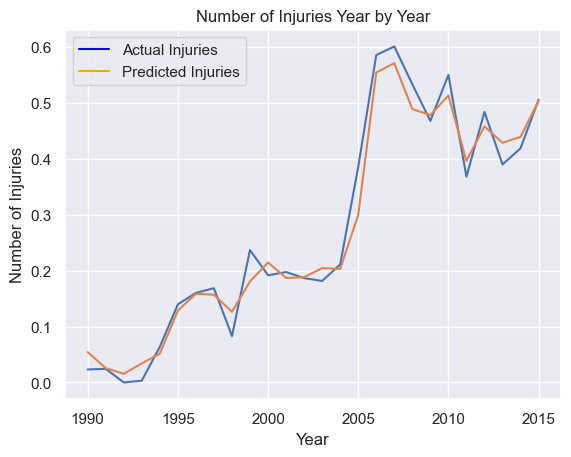

In [24]:
sns.set(style="darkgrid")
sns.lineplot(x=train_data['Year'], y=train_data['Injuries'], data=train_data)
sns.lineplot(x=train_data['Year'], y=train_data['prediction_insample'], data=train_data)
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Year by Year')
actual_injuries_legend = plt.Line2D([], [], color='blue', label='Actual Injuries')
predicted_injuries_legend = plt.Line2D([], [], color='orange', label='Predicted Injuries')
plt.legend(handles=[actual_injuries_legend, predicted_injuries_legend])



## Model Testing
<a id="4-MT"><a>

In [25]:
test_data = df[26:]
 
X_test = np.array(test_data[['Players', 'Games Played', 'Miles Traveled', 'Shortened Season', 'Average Age', 'salary', 'prevYrINJ']])
y_test = test_data['Injuries']


In [26]:
y_pred = fit_model.predict(X_test)
# Adding our insample prediction for each year to our test data set
test_data.loc[:, 'prediction_insample'] = y_pred.copy()
test_data.head()

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43073/1514185178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'prediction_insample'] = y_pred.copy()


,Year,Injuries,Players,isleagueExpansion,Miles Traveled,Average Age,salary,Games Played,prevYrINJ,Shortened Season,prediction_insample
26,2016,0.519305,1.0,1.0,0.909950,0.476190,0.416441,1.000000,0.505792,0.0,0.511905
27,2017,0.736165,1.0,1.0,0.945746,0.380952,0.513480,1.000000,0.519305,0.0,0.513758
28,2018,0.635779,1.0,1.0,0.963634,0.238095,0.597503,1.000000,0.736165,0.0,0.524884
29,2019,0.539254,1.0,1.0,0.921434,0.142857,0.863873,1.000000,0.635779,0.0,0.530727
30,2020,0.348777,1.0,1.0,0.380740,0.000000,0.815421,0.114105,0.539254,1.0,0.472420


In [27]:
test_data['error'] = test_data.prediction_insample - test_data.Injuries
test_data['squared_error'] = test_data['error']**2
test_data['abs'] = abs(test_data['error'])


/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43073/3584602971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['error'] = test_data.prediction_insample - test_data.Injuries
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43073/3584602971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['squared_error'] = test_data['error']**2
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43073/3584602971.py:3: SettingWithCopyWarning: 
A value is trying to be se

In [28]:
df.describe()["Injuries"]

count    34.000000
mean      0.352676
std       0.245394
min       0.000000
25%       0.171815
50%       0.358430
75%       0.529923
max       1.000000
Name: Injuries, dtype: float64

In [29]:
df

,Year,Injuries,Players,isleagueExpansion,Miles Traveled,Average Age,salary,Games Played,prevYrINJ,Shortened Season
0,1990,0.023166,0.0,0.0,0.694228,0.523810,0.096825,1.000000,0.023166,0.0
1,1991,0.024453,0.0,0.0,0.663674,0.571429,0.000000,1.000000,0.023166,0.0
2,1992,0.000000,0.0,0.0,0.735211,0.571429,0.014158,1.000000,0.024453,0.0
3,1993,0.003218,0.0,0.0,0.744093,0.666667,0.026549,1.000000,0.000000,0.0
4,1994,0.063707,0.0,0.0,0.739047,0.619048,0.050559,1.000000,0.003218,0.0
5,1995,0.139640,0.0,0.0,0.753839,0.809524,0.061001,1.000000,0.063707,0.0
6,1996,0.160232,0.0,0.0,0.875676,0.809524,0.104140,1.000000,0.139640,0.0
7,1997,0.168597,0.0,0.0,0.915565,0.952381,0.127307,1.000000,0.160232,0.0
8,1998,0.083012,0.0,0.0,0.858864,1.000000,0.148793,1.000000,0.168597,0.0
9,1999,0.236808,0.0,0.0,0.000000,0.952381,0.187475,0.001585,0.083012,1.0


### Plotting the Test Results
<a id="4.1-PTR"><a>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


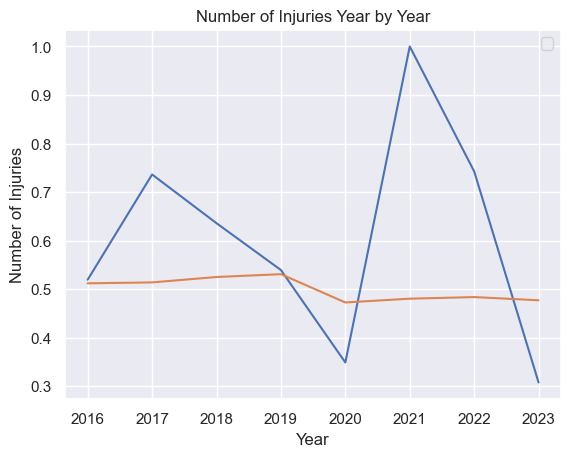

In [30]:
sns.set(style="darkgrid")
sns.lineplot(x=test_data['Year'], y=test_data['Injuries'], data=test_data)
sns.lineplot(x=test_data['Year'], y=test_data['prediction_insample'], data=test_data)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Year by Year')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()


## Conclusion
<a id="5-Conc"><a>

> **Below is a graph representing the features sorted from most to least important**

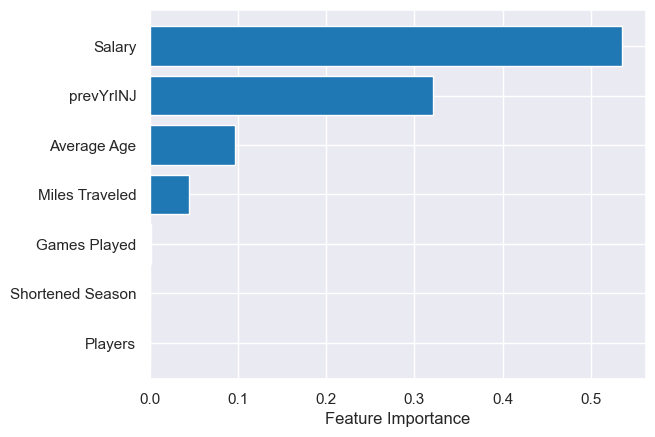

In [33]:
sort = weights.argsort()
sorted_feats = test_data.columns[sort]
sorted_weights = weights[sort]
feature_names = ['Players', 'Games Played', 'Miles Traveled', 'Shortened Season', 'Average Age', 'Salary', 'prevYrINJ']

# Adding the feature names to ensure proper representation on graph
sort_indices = np.argsort(weights)
sorted_feature_names = [feature_names[i] for i in sort_indices]
sorted_feature_weights = weights[sort_indices]

colors = ['tab:red' if w < 0 else 'tab:blue' for w in sorted_feature_weights]

plt.barh(sorted_feature_names, sorted_feature_weights, color=colors)
plt.xlabel("Feature Importance")
plt.show()


> **The most significant feature that had an impact on number of injuries was, not surprisingly the Age**

 >  **What was very surprising was the discovery that the number of games actually had an inverse affect on the total number of injuries**  

> **It appears based on the data that the more active players often seem to be the ones who get injured the least** 